# Упражнение с моделями разного качества

## Загрузки

In [3]:
!python --version

Python 3.12.4


In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [5]:
import numpy as np
import pandas as pd
from sklearn import metrics
from importlib import reload
import matplotlib.pyplot as plt
import DS_risk

In [6]:
# Для перезагрузки ранее импортированного модуля.
DS_risk = reload(DS_risk)
from DS_risk import World, Bank_DS, DWH_DB, Tariff, Contract, Portfolio, Model

## Инициализации

In [8]:
W = World()    # Инициализация мира


Проверим мир на ошибки.
test(AVG) -  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
test(0) -  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
test(1) -  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Hello World!


In [9]:
DS = Bank_DS() # Активности банка
DWH = DWH_DB() # Пародия на базу данных

Hello DS!


In [10]:
# Cut-off предопределенный 
print('Score = %g\nPD = %g' % (W.Fate_cutoff_score, DS.sigmoid(W.Fate_cutoff_score)))

Score = -0.847298
PD = 0.3


## Создание нулевой рисковой модели

In [12]:
model0 = DS.create_model()

In [13]:
model0.Model_Sigma = 1

In [14]:
model0.info()

Model_id: 1, Mu: 0, Sigma: 1, Calib koef: 0, 1


In [15]:
s = W.get_god_score(5)
s

[array([1.76405235, 0.40015721, 0.97873798, 2.2408932 , 1.86755799]),
 [1, 1, 1, 1, 1]]

In [16]:
m = model0.Score(s[0])
m

array([0.78677447, 1.35024563, 0.82738078, 2.13767435, 2.27815649])

## Создание тарифных планов

In [18]:
# Создадим тарифные планы
tariff_01 = Tariff('TR01')
tariff_01.info()

tariff_02 = Tariff('TR02', IR = 0.18, DUR = 36)
tariff_02.info()

Name: TR01 TypePlan = Annuity IR = 0.12 Duration = 24 MD = 11.9046
Name: TR02 TypePlan = Annuity IR = 0.18 Duration = 36 MD = 16.6512


In [19]:
tariff_01.print_plan(amount=100_000)

 N [' Долг+проц', '    Платеж', 'Плат(долг)', 'Плат(проц)', '  Кум долг', '  Кум проц', 'Кум оплаты']
01 [' 101000.00', '   4707.35', '   3707.35', '   1000.00', '   3707.35', '   1000.00', '   4707.35']
02 ['  97255.58', '   4707.35', '   3744.42', '    962.93', '   7451.77', '   1962.93', '   9414.69']
03 ['  93473.71', '   4707.35', '   3781.86', '    925.48', '  11233.63', '   2888.41', '  14122.04']
04 ['  89654.03', '   4707.35', '   3819.68', '    887.66', '  15053.32', '   3776.07', '  18829.39']
05 ['  85796.15', '   4707.35', '   3857.88', '    849.47', '  18911.20', '   4625.54', '  23536.74']
06 ['  81899.69', '   4707.35', '   3896.46', '    810.89', '  22807.66', '   5436.43', '  28244.08']
07 ['  77964.27', '   4707.35', '   3935.42', '    771.92', '  26743.08', '   6208.35', '  32951.43']
08 ['  73989.49', '   4707.35', '   3974.78', '    732.57', '  30717.86', '   6940.92', '  37658.78']
09 ['  69974.96', '   4707.35', '   4014.53', '    692.82', '  34732.38', '   7633

## Создание портфеля

In [21]:
# Создадим портфели
GP1 = Portfolio(world = W, dwh = DWH)
GP2 = Portfolio(world = W, dwh = DWH)
GP3 = Portfolio(world = W, dwh = DWH)
GP1.info()
GP2.info()
GP3.info()

ID = 1 Возраст портеля 0 мес Кол-во контрактов 0
ID = 2 Возраст портеля 0 мес Кол-во контрактов 0
ID = 3 Возраст портеля 0 мес Кол-во контрактов 0


In [22]:
N_const = 3000 # Пусть будут постоянные ежемесячные выдачи

In [61]:
# Создадим план продаж на основе созданных тарифных планов
#issue_plan_gp = [(tariff_01, 100_000) for i in range(N_const//2)] + [(tariff_02, 50_000) for i in range(N_const//2)]
#issue_plan_il = [(tariff_01, 30_000) for i in range(N_const//2)]
issue_plan_gp = [(tariff_01, 30_000) for i in range(N_const)]
print(len(issue_plan_gp))
#print(len(issue_plan_il))

3000


In [62]:
# фиксируем Cut_off
pd_cutoff = 0.15
score_cutoff = DS.logit(pd_cutoff)
print('%g' % score_cutoff)

-1.7346


In [63]:
for t in range(2*12):
    GP1.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model0)
    GP2.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model0)
    GP3.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model0)

DWH.update_dwh_dic() # обновим справочники DWH
GP1.info()
GP2.info()
GP3.info()

ID = 1 Возраст портеля 24 мес Кол-во контрактов 72000
ID = 2 Возраст портеля 24 мес Кол-во контрактов 72000
ID = 3 Возраст портеля 24 мес Кол-во контрактов 72000


## Обратимся к базе данных

In [65]:
LI = DWH.LI.reset_index(drop=True)
print(LI.shape)
ix_bad = LI['DOD_ID']>=4
LI['BADFLAG'] = 0
LI.loc[ix_bad,'BADFLAG'] = 1
LI.tail()

(2700000, 7)


,PORTFOLIO_ID,CNTR_ID,SD,DOD_ID,MOB,WRTOFF_ID,CLOSED_ID,BADFLAG
2699995,3,215996,24,0,0,0,0,0
2699996,3,215997,24,0,0,0,0,0
2699997,3,215998,24,0,0,0,0,0
2699998,3,215999,24,0,0,0,0,0
2699999,3,216000,24,0,0,0,0,0


In [66]:
Contract.cntr_dic[13].duration

24

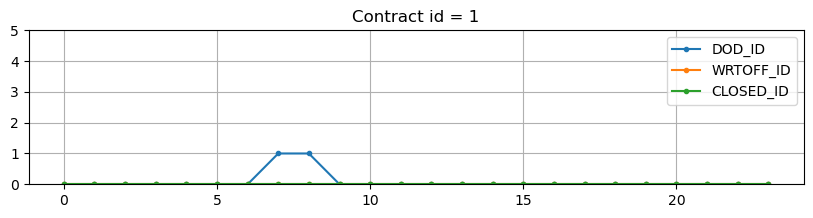

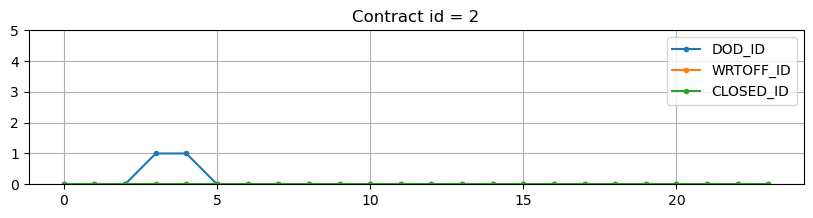

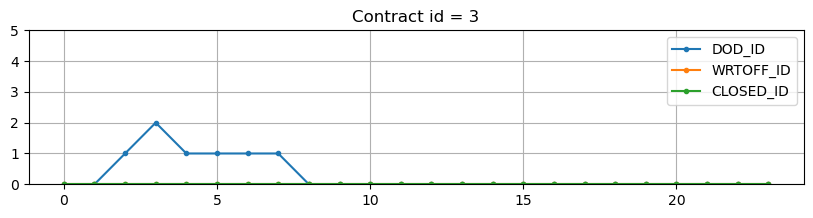

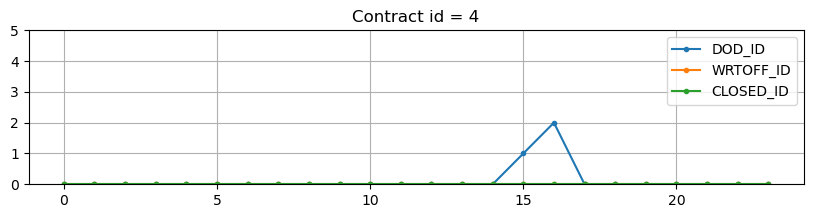

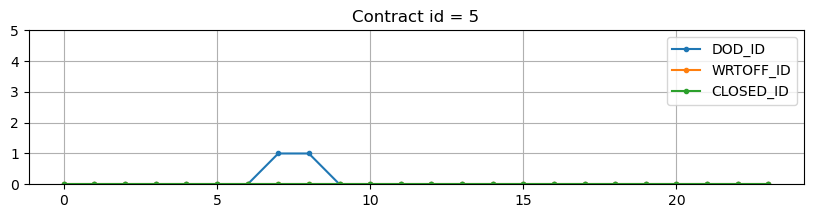

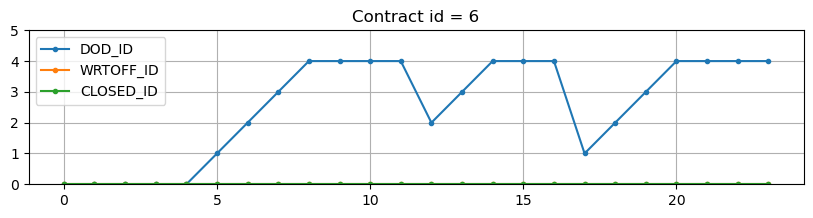

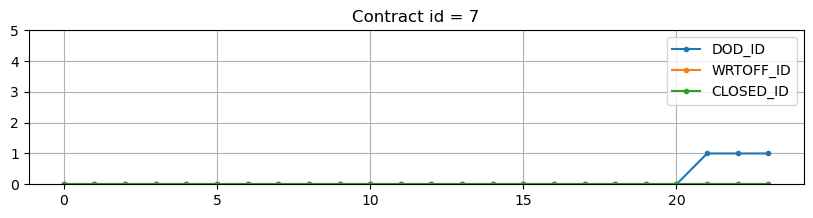

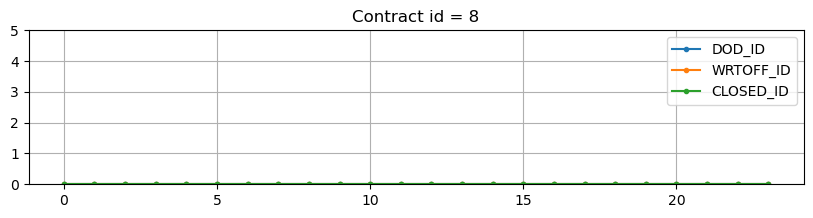

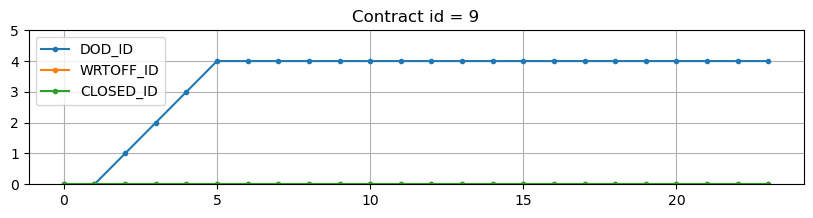

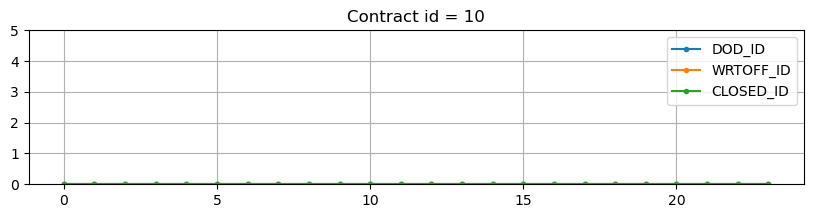

In [67]:
for i in range(1,11):
    ix = LI['CNTR_ID']==i
    plt.figure(figsize=[10,2])
    plt.title('Contract id = %i'%i)
    plt.plot(LI[ix].set_index('MOB')[['DOD_ID', 'WRTOFF_ID', 'CLOSED_ID']], '.-')
    plt.legend(['DOD_ID', 'WRTOFF_ID', 'CLOSED_ID'])
    plt.ylim([0,5])
    plt.grid()
    plt.show()

In [68]:
DMC = DWH.DMContract
print(DMC.shape)
DMC.head(10)

(216000, 15)


,PORTFOLIO_ID,CNTR_ID,ISSUE_DT,WRTOFF_DT,CLOSED_DT,AMOUNT,DURATION,IR,TARIFF,MODEL_PD,MODEL_SCORE,FATED_SCORE,FATED_RESULT,MODEL_ID,NUM_IN_QUEUE
0,1,1,1,0,0,30000,24,0.12,TR01,0.044114,-3.075850,-2.060141,0,1,11
1,1,2,1,0,0,30000,24,0.12,TR01,0.083542,-2.395166,-1.099891,0,1,4
2,1,3,1,0,0,30000,24,0.12,TR01,0.041962,-3.128134,-0.877858,0,1,2
3,1,4,1,0,0,30000,24,0.12,TR01,0.124266,-1.952641,-1.100619,0,1,3
4,1,5,1,0,0,30000,24,0.12,TR01,0.129057,-1.909319,-1.117310,0,1,16
5,1,6,1,0,0,30000,24,0.12,TR01,0.093498,-2.271657,-0.191836,1,1,4
6,1,7,1,0,0,30000,24,0.12,TR01,0.145658,-1.769073,-1.142518,0,1,12
7,1,8,1,0,0,30000,24,0.12,TR01,0.090501,-2.307533,-1.396496,0,1,17
8,1,9,1,0,0,30000,24,0.12,TR01,0.128612,-1.913285,0.377564,1,1,18
9,1,10,1,0,0,30000,24,0.12,TR01,0.077610,-2.475265,-1.373117,0,1,23


In [69]:
DMC[DMC['FATED_RESULT']==1].head()

,PORTFOLIO_ID,CNTR_ID,ISSUE_DT,WRTOFF_DT,CLOSED_DT,AMOUNT,DURATION,IR,TARIFF,MODEL_PD,MODEL_SCORE,FATED_SCORE,FATED_RESULT,MODEL_ID,NUM_IN_QUEUE
5,1,6,1,0,0,30000,24,0.12,TR01,0.093498,-2.271657,-0.191836,1,1,4
8,1,9,1,0,0,30000,24,0.12,TR01,0.128612,-1.913285,0.377564,1,1,18
12,1,13,1,0,0,30000,24,0.12,TR01,0.087263,-2.347517,0.682551,1,1,17
13,1,14,1,0,0,30000,24,0.12,TR01,0.126023,-1.936590,-0.310117,1,1,1
17,1,18,1,0,0,30000,24,0.12,TR01,0.051162,-2.920248,-0.434957,1,1,11


In [70]:
DMC.tail(10)

,PORTFOLIO_ID,CNTR_ID,ISSUE_DT,WRTOFF_DT,CLOSED_DT,AMOUNT,DURATION,IR,TARIFF,MODEL_PD,MODEL_SCORE,FATED_SCORE,FATED_RESULT,MODEL_ID,NUM_IN_QUEUE
215990,3,215991,24,0,0,30000,24,0.12,TR01,0.084819,-2.378602,-1.099151,0,1,4
215991,3,215992,24,0,0,30000,24,0.12,TR01,0.046636,-3.017627,-0.730712,1,1,10
215992,3,215993,24,0,0,30000,24,0.12,TR01,0.114711,-2.043494,-1.025025,0,1,10
215993,3,215994,24,0,0,30000,24,0.12,TR01,0.095609,-2.247000,-0.826942,1,1,30
215994,3,215995,24,0,0,30000,24,0.12,TR01,0.067677,-2.622930,-0.518971,1,1,12
215995,3,215996,24,0,0,30000,24,0.12,TR01,0.016701,-4.075429,-2.415116,0,1,4
215996,3,215997,24,0,0,30000,24,0.12,TR01,0.055535,-2.833610,-0.813381,1,1,7
215997,3,215998,24,0,0,30000,24,0.12,TR01,0.068540,-2.609330,-2.204644,0,1,18
215998,3,215999,24,0,0,30000,24,0.12,TR01,0.085780,-2.366287,-1.616356,0,1,19
215999,3,216000,24,0,0,30000,24,0.12,TR01,0.054440,-2.854677,-1.046564,0,1,21


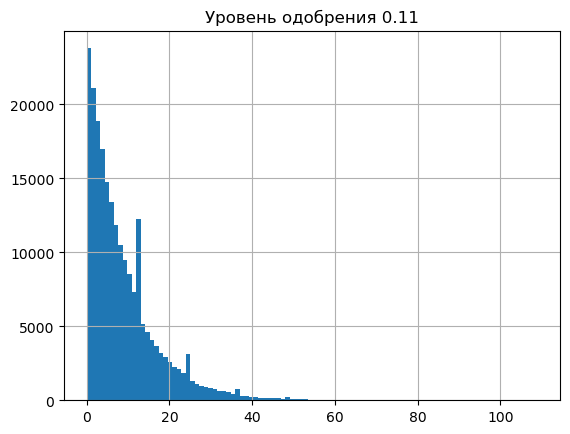

In [71]:
DMC.set_index('CNTR_ID')[['NUM_IN_QUEUE']].hist(bins=100)
plt.title('Уровень одобрения %0.2f' % (1/DMC['NUM_IN_QUEUE'].mean()))
#plt.yscale('log')
plt.show()

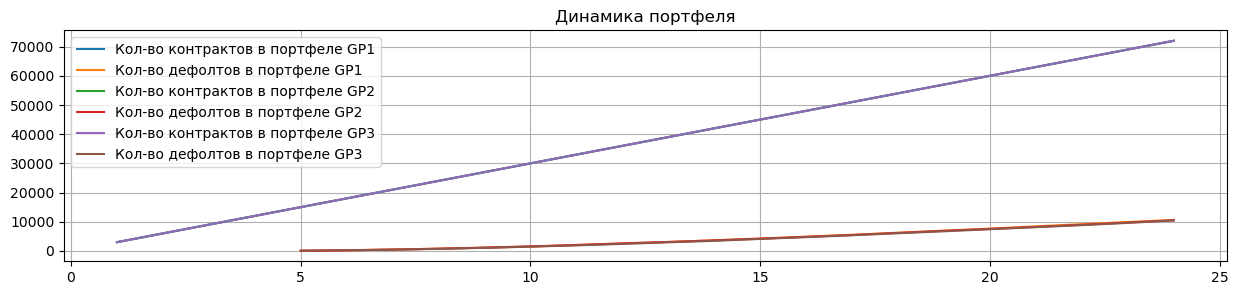

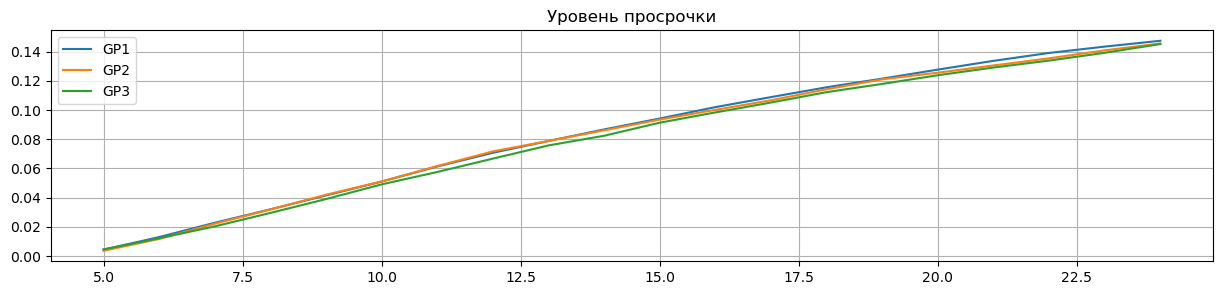

In [72]:
portfolio_list = LI['PORTFOLIO_ID'].unique()

ix = ((LI['WRTOFF_ID'] == 0)&
      (LI['CLOSED_ID'] == 0)
     )
ix_bad = LI['BADFLAG'] == 1

plt.figure(figsize=[15,3])
plt.title('Динамика портфеля')
T = {}
B = {}
leg = []
for p in portfolio_list:
    ix_gp = LI['PORTFOLIO_ID'] == p
    T[p] = LI[ix_gp&ix].groupby('SD')[['CNTR_ID']].count()
    B[p] = LI[ix_gp&ix&ix_bad].groupby('SD')[['CNTR_ID']].count()
    plt.plot(T[p])
    plt.plot(B[p])
    leg.append('Кол-во контрактов в портфеле GP%s' % p)
    leg.append('Кол-во дефолтов в портфеле GP%s' % p)
plt.legend(leg)
plt.grid()
plt.show()

plt.figure(figsize=[15,3])
plt.title('Уровень просрочки')
leg = []
for p in portfolio_list:
    plt.plot(B[p]/T[p])
    leg.append('GP%s' % p)
plt.legend(leg)
plt.grid()
plt.show()

In [73]:
col_on = ['PORTFOLIO_ID', 'CNTR_ID']
col_dmc = ['MODEL_SCORE', 'FATED_SCORE'] + col_on
ix = LI['MOB'] == 12
T = LI[ix].merge(DMC[col_dmc], on = col_on, how = 'left')

In [74]:
D_stat = {}
for p in portfolio_list:
    ix_p = T['PORTFOLIO_ID'] == p
    sd_list = T[ix_p]['SD'].unique()
    dic_stat = {}
    for sd in sd_list:
        ix = T['SD'] == sd
        dic_stat[sd-12] = [DS.gini(T[ix & ix_p], target = 'BADFLAG', score = 'MODEL_SCORE'),
                           T[ix & ix_p]['BADFLAG'].mean()
                          ]
    D_stat[p] = pd.DataFrame.from_dict(dic_stat, orient = 'index', columns=['GINI_%s'%p, 'DR_%s'%p])

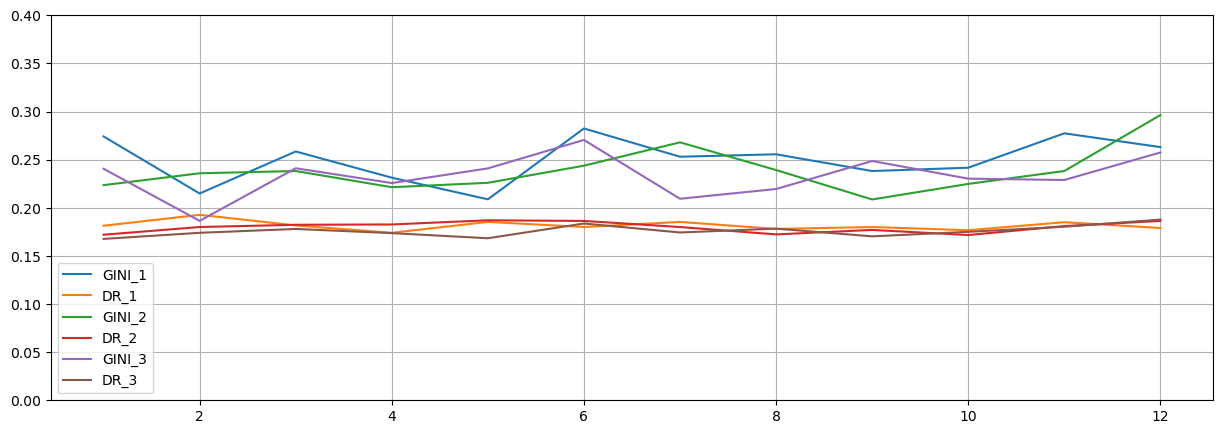

In [75]:
plt.figure(figsize=[15,5])
plt.ylim([0,0.4])
leg = []
for p in portfolio_list:
    plt.plot(D_stat[p])
    leg = leg + list(D_stat[p].columns)
plt.legend(leg)
plt.grid()
plt.show()

## Обучим модели на данных портфеля

In [77]:
TT = T.copy()

In [78]:
TT.tail()

,PORTFOLIO_ID,CNTR_ID,SD,DOD_ID,MOB,WRTOFF_ID,CLOSED_ID,BADFLAG,MODEL_SCORE,FATED_SCORE
107995,3,107996,24,0,12,0,0,0,-2.412569,-1.954720
107996,3,107997,24,0,12,0,0,0,-3.197210,-1.235912
107997,3,107998,24,4,12,0,0,1,-2.468288,-0.802114
107998,3,107999,24,4,12,0,0,1,-1.825595,-0.243075
107999,3,108000,24,0,12,0,0,0,-2.109085,-2.726168


In [79]:
model_dic = {}
for i, gini in zip([1,2,3],[0.30, 0.50, 0.70]):
    ix = TT['PORTFOLIO_ID'] == i
    model_dic[i] = DS.create_model(gini = gini, tto_sample=TT[ix])
    model_dic[i].info()

Model_id: 2, Mu: 0, Sigma: 1.673, Calib koef: 0, 1
Model_id: 3, Mu: 0, Sigma: 0.82, Calib koef: 0, 1
Model_id: 4, Mu: 0, Sigma: 0.32, Calib koef: 0, 1


In [80]:
model_dic

{1: <DS_risk.Model at 0x7049a8d501a0>,
 2: <DS_risk.Model at 0x7049aacdf050>,
 3: <DS_risk.Model at 0x7049aae4fb60>}

In [81]:
model_dic[1].log_dic['root_scalar'].root

1.6726116303559107

In [82]:
model2 = model_dic[1]

In [83]:
model2.log_dic['dic_fun']

{0.0: 0.775645644928572,
 5.0: 0.1075791499309778,
 3.5598675318261908: 0.1506271544206645,
 1.7799337659130954: 0.28571908042752164,
 1.6243413291818645: 0.30743484176249536,
 1.6776116303559114: 0.29979593304620616,
 1.6726116303559107: 0.2994844363954155,
 1.6484764797688876: 0.30449448514260136,
 1.6676116303559099: 0.301029506229947}

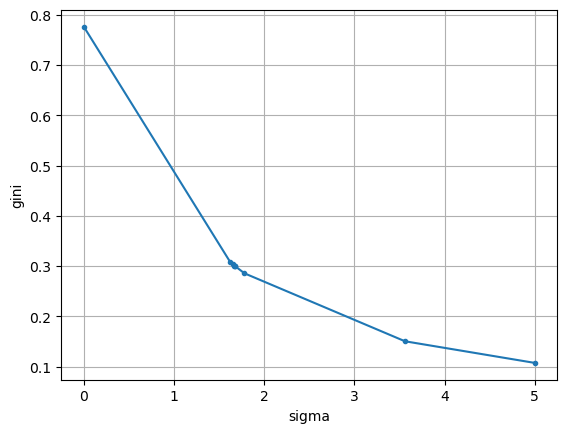

In [84]:
dic_fun = model2.log_dic['dic_fun']
x = list(dic_fun.keys())
x.sort()
y = [dic_fun[k] for k in x]
plt.plot(x, y, '.-')
plt.xlabel('sigma')
plt.ylabel('gini')
plt.grid()

In [85]:
TT

,PORTFOLIO_ID,CNTR_ID,SD,DOD_ID,MOB,WRTOFF_ID,CLOSED_ID,BADFLAG,MODEL_SCORE,FATED_SCORE
0,1,1,13,0,12,0,0,0,-3.075850,-2.060141
1,1,2,13,0,12,0,0,0,-2.395166,-1.099891
2,1,3,13,0,12,0,0,0,-3.128134,-0.877858
3,1,4,13,0,12,0,0,0,-1.952641,-1.100619
4,1,5,13,0,12,0,0,0,-1.909319,-1.117310
...,...,...,...,...,...,...,...,...,...,...
107995,3,107996,24,0,12,0,0,0,-2.412569,-1.954720
107996,3,107997,24,0,12,0,0,0,-3.197210,-1.235912
107997,3,107998,24,4,12,0,0,1,-2.468288,-0.802114
107998,3,107999,24,4,12,0,0,1,-1.825595,-0.243075


## Проведем калибровки

In [87]:
for i in model_dic:
    ix = TT['PORTFOLIO_ID'] == i
    TT.loc[ix, 'MODEL_SCORE_%s'%i] = model_dic[i].Score(np.array(TT[ix]['FATED_SCORE'].values))

In [88]:
for i in model_dic:
    ix = TT['PORTFOLIO_ID'] == i
    TT.loc[ix, 'MODEL_SCORE'] = TT.loc[ix, 'MODEL_SCORE_%s'%i]
    print(i, DS.calibration(model = model_dic[i], sample = TT[ix]))

1 (-1.2301186130812083, 0.30681590819144083)
2 (-0.7493537566811556, 0.8536572707773029)
3 (0.06236669034017345, 1.84376856742937)


In [89]:
model2.log_dic

{'root_scalar':       converged: True
            flag: converged
  function_calls: 9
      iterations: 8
            root: 1.6726116303559107
          method: brentq,
 'dic_fun': {0.0: 0.775645644928572,
  5.0: 0.1075791499309778,
  3.5598675318261908: 0.1506271544206645,
  1.7799337659130954: 0.28571908042752164,
  1.6243413291818645: 0.30743484176249536,
  1.6776116303559114: 0.29979593304620616,
  1.6726116303559107: 0.2994844363954155,
  1.6484764797688876: 0.30449448514260136,
  1.6676116303559099: 0.301029506229947},
 'LR': LogisticRegression(random_state=42)}

In [90]:
for i in model_dic:
    ix = TT['PORTFOLIO_ID'] == i
    TT.loc[ix, 'PD'] = model_dic[i].PD(TT.loc[ix, 'MODEL_SCORE_%s'%i])
    print(i, 'PD_mean %0.4f' %  TT.loc[ix, 'PD'].mean(), 'DR_mean %0.4f' % TT.loc[ix, 'BADFLAG'].mean())
DS.grade(TT, 'PD', 'GRADE')

1 PD_mean 0.1816 DR_mean 0.1816
2 PD_mean 0.1798 DR_mean 0.1799
3 PD_mean 0.1759 DR_mean 0.1759


In [91]:
col_pd = [c for c in TT.columns if 'PD' in c[:2]]
col_pd

['PD']

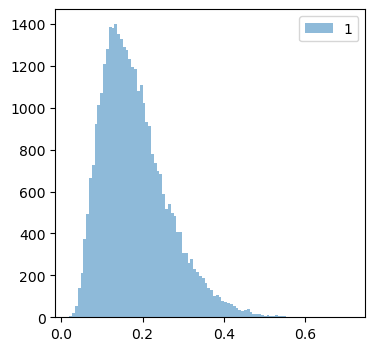

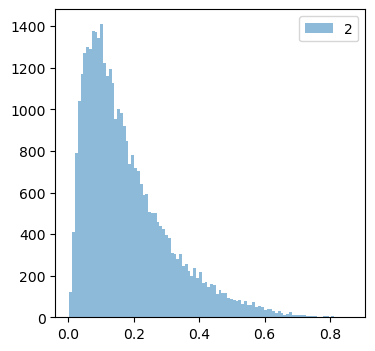

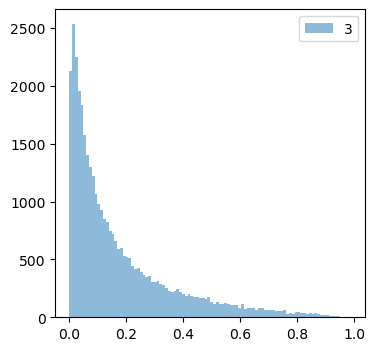

In [92]:
for i in model_dic:
    plt.figure(figsize=[4,4])
    ix = TT['PORTFOLIO_ID'] == i
    plt.hist(TT[ix]['PD'],bins=100, alpha = 0.5)
    plt.legend('%i'%i)
    plt.show()

In [93]:
TT_GR = {}
for i in model_dic:
    ix = TT['PORTFOLIO_ID'] == i
    TT_GR[i] = TT[ix].groupby('GRADE')[['BADFLAG', 'PD']].mean().rename(columns = {'BADFLAG': 'DR_%s'%i, 'PD': 'PD_MEAN_%s'%i})
    TT_GR[i]['CNT_%s'%i] = TT[ix].groupby('GRADE')[['BADFLAG']].count()

In [94]:
#TT_GR = TT.groupby('GRADE')[['BADFLAG', 'PD']].mean().rename(columns = {'BADFLAG': 'DR', 'PD': 'PD_MEAN'})
#TT_GR['PD_MEDIAN'] = TT.groupby('GRADE')[['PD']].median()
#TT_GR['CNT'] = TT.groupby('GRADE')[['BADFLAG']].count()

In [95]:
# col_cnt = [c for c in TT_GR.columns if c[:3] in ['CNT']]
# TT_GR[col_cnt].sum()

In [96]:
TT_GR_ = pd.concat([TT_GR[i].T for i in TT_GR]).T.sort_index()

In [97]:
TT_GR_

,DR_1,PD_MEAN_1,CNT_1,DR_2,PD_MEAN_2,CNT_2,DR_3,PD_MEAN_3,CNT_3
GRADE,,,,,,,,,
1,NaN,NaN,NaN,0.000000,0.004294,8.0,0.012834,0.003400,935.0
2,NaN,NaN,NaN,0.000000,0.006761,17.0,0.011804,0.006657,593.0
3,NaN,NaN,NaN,0.000000,0.009562,80.0,0.007398,0.009450,811.0
4,NaN,NaN,NaN,0.012121,0.013504,165.0,0.006499,0.013333,1231.0
5,0.000000,0.019279,1.0,0.016746,0.019341,418.0,0.006301,0.018818,1587.0
6,0.000000,0.027831,16.0,0.017505,0.027112,914.0,0.008828,0.026546,2039.0
7,0.030075,0.039642,133.0,0.018507,0.037966,1675.0,0.012331,0.037654,2514.0
8,0.046980,0.055299,745.0,0.042285,0.053633,2696.0,0.017655,0.053073,3002.0
9,0.065209,0.076918,2653.0,0.063116,0.075625,4056.0,0.030231,0.075137,3374.0


In [98]:
DS.print_master_scale()

Grage Right_value
    1 0.00552
    2 0.00781
    3 0.011
    4 0.0156
    5 0.0221
    6 0.0312
    7 0.0442
    8 0.0625
    9 0.0884
   10 0.125
   11 0.177
   12 0.25
   13 0.354
   14 0.5
   15 0.707
   16 1


['DR_1', 'PD_MEAN_1', 'DR_2', 'PD_MEAN_2', 'DR_3', 'PD_MEAN_3']


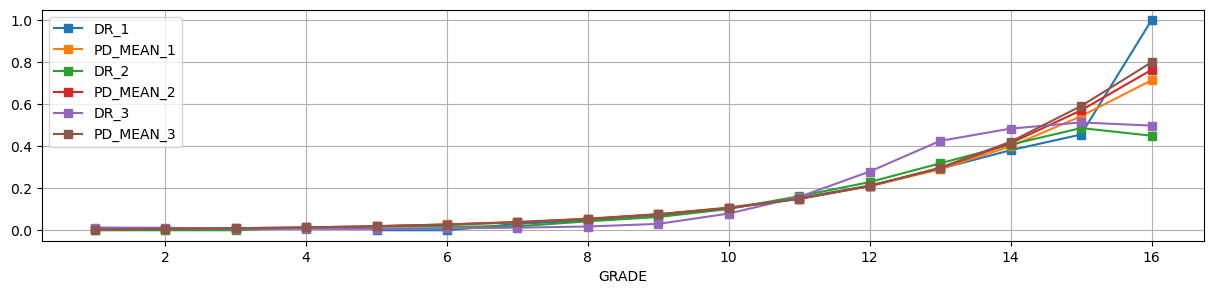

In [99]:
col_gr = [c for c in TT_GR_.columns if c[:2] in ['PD', 'DR']]
print(col_gr)
TT_GR_[col_gr].plot(figsize=[15,3], marker = 's')
plt.grid()
plt.legend(col_gr)
    # ['DR - уровень дефолта рейтинга',
    #         'PD - среднее значение вероятности дефлота в рейтинге',
    #         'PD - медианное значение вероятности дефлота в рейтинге'])


['CNT_1', 'CNT_2', 'CNT_3']


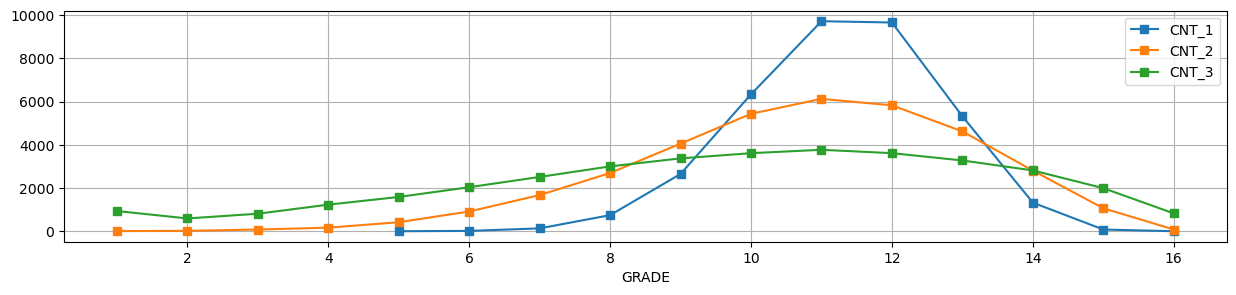

In [100]:
col_gr = [c for c in TT_GR_.columns if c[:3] in ['CNT']]
print(col_gr)
TT_GR_[col_gr].plot(figsize=[15,3], marker = 's')
plt.grid()
plt.legend(col_gr)
    # ['DR - уровень дефолта рейтинга',
    #         'PD - среднее значение вероятности дефлота в рейтинге',
    #         'PD - медианное значение вероятности дефлота в рейтинге'])
#plt.yscale('log')
plt.show()

In [101]:
model_dic

{1: <DS_risk.Model at 0x7049a8d501a0>,
 2: <DS_risk.Model at 0x7049aacdf050>,
 3: <DS_risk.Model at 0x7049aae4fb60>}

## Применим новые модели при одобрении

In [103]:
pd_cutoff = 0.05
pd_cutoff

0.05

In [104]:
for t in range(2*12):
    GP1.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[1])
    GP2.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[2])
    GP3.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[3])

DWH.update_dwh_dic() # обновим справочники DWH
GP1.info()
GP2.info()
GP3.info()

ID = 1 Возраст портеля 48 мес Кол-во контрактов 93232
ID = 2 Возраст портеля 48 мес Кол-во контрактов 93097
ID = 3 Возраст портеля 48 мес Кол-во контрактов 93122


In [105]:
pd_cutoff = 0.1
pd_cutoff

0.1

In [106]:
for t in range(2*12):
    GP1.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[1])
    GP2.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[2])
    GP3.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[3])

DWH.update_dwh_dic() # обновим справочники DWH
GP1.info()
GP2.info()
GP3.info()

ID = 1 Возраст портеля 72 мес Кол-во контрактов 90040
ID = 2 Возраст портеля 72 мес Кол-во контрактов 83731
ID = 3 Возраст портеля 72 мес Кол-во контрактов 79925


In [199]:
pd_cutoff = 0.15
pd_cutoff

0.15

In [201]:
for t in range(2*12):
    GP1.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[1])
    GP2.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[2])
    GP3.next_month(issue_plan_gp, pd_cutoff = pd_cutoff, model = model_dic[3])

DWH.update_dwh_dic() # обновим справочники DWH
GP1.info()
GP2.info()
GP3.info()

ID = 1 Возраст портеля 96 мес Кол-во контрактов 101445
ID = 2 Возраст портеля 96 мес Кол-во контрактов 90479
ID = 3 Возраст портеля 96 мес Кол-во контрактов 79651


In [202]:
LI = DWH.LI.reset_index(drop=True)
ix_bad = LI['DOD_ID']>=4
LI['BADFLAG'] = 0
LI.loc[ix_bad,'BADFLAG'] = 1
print(LI.shape)
LI.tail()

(21501108, 8)


,PORTFOLIO_ID,CNTR_ID,SD,DOD_ID,MOB,WRTOFF_ID,CLOSED_ID,BADFLAG
21501103,3,863996,96,0,0,0,0,0
21501104,3,863997,96,0,0,0,0,0
21501105,3,863998,96,0,0,0,0,0
21501106,3,863999,96,0,0,0,0,0
21501107,3,864000,96,0,0,0,0,0


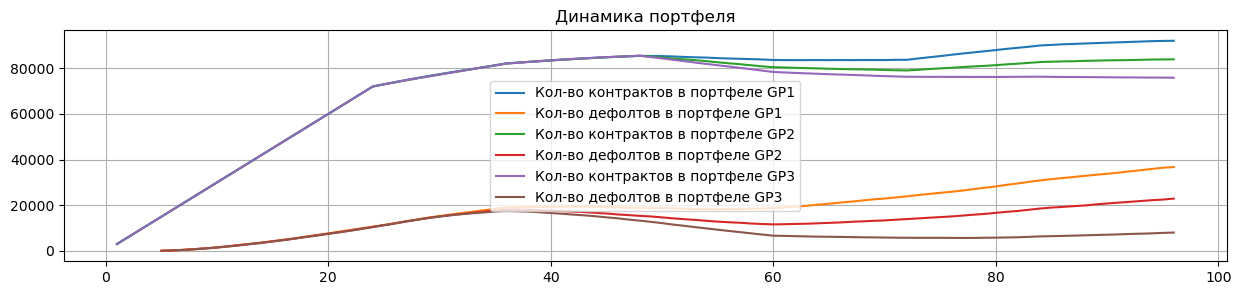

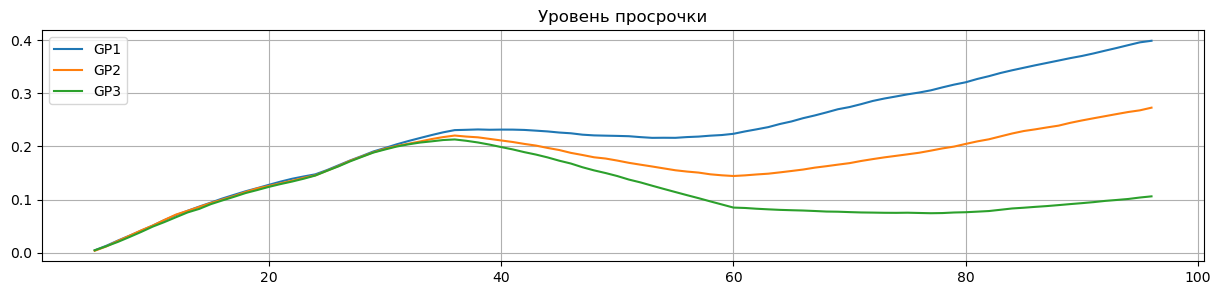

In [204]:
portfolio_list = LI['PORTFOLIO_ID'].unique()

ix = ((LI['WRTOFF_ID'] == 0)&
      (LI['CLOSED_ID'] == 0)
     )
ix_bad = LI['BADFLAG'] == 1

plt.figure(figsize=[15,3])
plt.title('Динамика портфеля')
T = {}
B = {}
leg = []
for p in portfolio_list:
    ix_gp = LI['PORTFOLIO_ID'] == p
    T[p] = LI[ix_gp&ix].groupby('SD')[['CNTR_ID']].count()
    B[p] = LI[ix_gp&ix&ix_bad].groupby('SD')[['CNTR_ID']].count()
    plt.plot(T[p])
    plt.plot(B[p])
    leg.append('Кол-во контрактов в портфеле GP%s' % p)
    leg.append('Кол-во дефолтов в портфеле GP%s' % p)
plt.legend(leg)
plt.grid()
plt.show()

plt.figure(figsize=[15,3])
plt.title('Уровень просрочки')
leg = []
for p in portfolio_list:
    plt.plot(B[p]/T[p])
    leg.append('GP%s' % p)
plt.legend(leg)
plt.grid()
plt.show()

In [207]:
for p in Portfolio.portfolio_dic:
    Portfolio.portfolio_dic[p].info()

ID = 1 Возраст портеля 96 мес Кол-во контрактов 101445
ID = 2 Возраст портеля 96 мес Кол-во контрактов 90479
ID = 3 Возраст портеля 96 мес Кол-во контрактов 79651


In [208]:
for m in Model.model_dic:
    Model.model_dic[m].info()

Model_id: 1, Mu: 0, Sigma: 1, Calib koef: 0, 1
Model_id: 2, Mu: 0, Sigma: 1.673, Calib koef: -1.23012, 0.306816
Model_id: 3, Mu: 0, Sigma: 0.82, Calib koef: -0.749354, 0.853657
Model_id: 4, Mu: 0, Sigma: 0.32, Calib koef: 0.0623667, 1.84377


In [209]:
for m in model_dic:
    print(m, end=' ')
    model_dic[m].info()

1 Model_id: 2, Mu: 0, Sigma: 1.673, Calib koef: -1.23012, 0.306816
2 Model_id: 3, Mu: 0, Sigma: 0.82, Calib koef: -0.749354, 0.853657
3 Model_id: 4, Mu: 0, Sigma: 0.32, Calib koef: 0.0623667, 1.84377


In [210]:
DMC = DWH.DMContract

In [211]:
ix = DMC['ISSUE_DT'] <= 24
DMC[ix].groupby('PORTFOLIO_ID')['NUM_IN_QUEUE'].mean()

PORTFOLIO_ID
1    9.079903
2    9.130694
3    9.071847
Name: NUM_IN_QUEUE, dtype: float64

In [212]:
ix = DMC['ISSUE_DT'] > 24
DMC[ix].groupby('PORTFOLIO_ID')['NUM_IN_QUEUE'].mean()

PORTFOLIO_ID
1    168.541144
2     19.641713
3     10.219824
Name: NUM_IN_QUEUE, dtype: float64

In [251]:
col_on = ['PORTFOLIO_ID', 'CNTR_ID']
col_dmc = ['MODEL_PD', 'MODEL_SCORE', 'FATED_SCORE', 'FATED_RESULT', 'MODEL_ID'] + col_on
ix = LI['MOB'] == 12
T = LI[ix].merge(DMC[col_dmc], on = col_on, how = 'left')


In [257]:
for m in Model.model_dic:
    ix_m = T['MODEL_ID'] == m
    T.loc[ix_m, 'PD'] = Model.model_dic[m].PD(T.loc[ix_m, 'MODEL_SCORE'])

In [259]:
DS.grade(T)

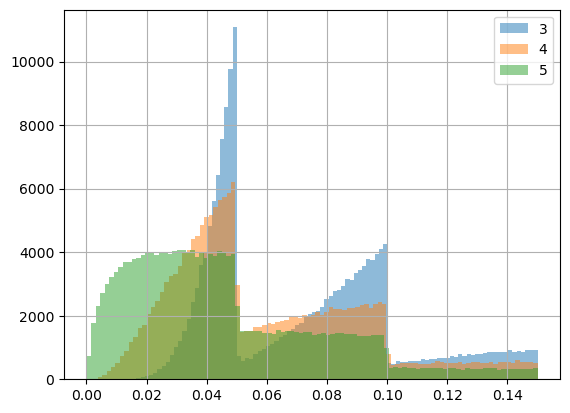

In [261]:
ix_sd = T['SD'] > 36
T[ix_sd].groupby('MODEL_ID')['PD'].hist(bins=100, alpha = 0.5)
plt.legend([3,4,5])

In [263]:
D_stat = {}
for p in portfolio_list:
    ix_p = T['PORTFOLIO_ID'] == p
    sd_list = T[ix_p]['SD'].unique()
    dic_stat = {}
    for sd in sd_list:
        ix = T['SD'] == sd
        dic_stat[sd-12] = [DS.gini(T[ix & ix_p], target = 'BADFLAG', score = 'MODEL_SCORE'),
                           T[ix & ix_p]['BADFLAG'].mean()
                          ]
    D_stat[p] = pd.DataFrame.from_dict(dic_stat, orient = 'index', columns=['GINI_%s'%p, 'DR_%s'%p])

In [271]:
D_fate = {}
for p in portfolio_list:
    ix_p = T['PORTFOLIO_ID'] == p
    sd_list = T[ix_p]['SD'].unique()
    dic_stat = {}
    for sd in sd_list:
        ix = T['SD'] == sd
        dic_stat[sd-12] = [DS.gini(T[ix & ix_p], target = 'BADFLAG', score = 'FATED_SCORE'),
                           T[ix & ix_p]['BADFLAG'].mean()
                          ]
    D_fate[p] = pd.DataFrame.from_dict(dic_stat, orient = 'index', columns=['GINI_%s'%p, 'DR_%s'%p])

In [265]:
T[ix & ix_p]

,PORTFOLIO_ID,CNTR_ID,SD,DOD_ID,MOB,WRTOFF_ID,CLOSED_ID,BADFLAG,MODEL_PD,MODEL_SCORE,FATED_SCORE,FATED_RESULT,MODEL_ID,SCORE_DIFF,PD,GRADE
753000,3,753001,96,0,12,0,0,0,0.077579,-1.376569,-0.972285,0,4,-0.404284,0.077579,9
753001,3,753002,96,0,12,0,0,0,0.007166,-2.708351,-2.138764,0,4,-0.569587,0.007166,2
753002,3,753003,96,0,12,0,0,0,0.143956,-1.000768,-0.608106,1,4,-0.392662,0.143956,11
753003,3,753004,96,0,12,0,0,0,0.148719,-0.980087,-0.739439,1,4,-0.240648,0.148719,11
753004,3,753005,96,3,12,0,0,0,0.018709,-2.181514,-1.977589,0,4,-0.203925,0.018709,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755995,3,755996,96,0,12,0,0,0,0.130703,-1.061480,-0.950294,0,4,-0.111186,0.130703,11
755996,3,755997,96,4,12,0,0,1,0.047401,-1.661227,-0.763661,1,4,-0.897566,0.047401,8
755997,3,755998,96,0,12,0,0,0,0.073847,-1.405493,-0.962953,0,4,-0.442540,0.073847,9
755998,3,755999,96,0,12,0,0,0,0.144716,-0.997429,-0.961315,0,4,-0.036114,0.144716,11


In [223]:
T.groupby(['PORTFOLIO_ID', 'MODEL_ID'])[['SD']].agg(['min', 'max'])-12

SD    
                      min max
PORTFOLIO_ID MODEL_ID        
1            1          1  24
             2         25  84
2            1          1  24
             3         25  84
3            1          1  24
             4         25  84

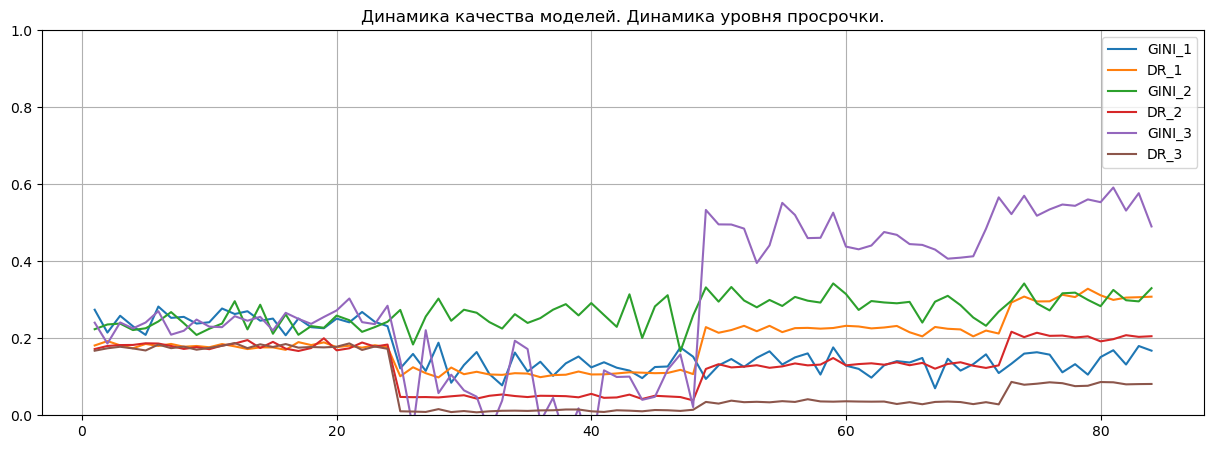

In [247]:
plt.figure(figsize=[15,5])
plt.ylim([0,None])
leg = []
for p in portfolio_list:
    plt.plot(D_stat[p])
    leg = leg + list(D_stat[p].columns)
plt.legend(leg)
plt.title('Динамика качества моделей. Динамика уровня просрочки.')
plt.grid()
plt.show()

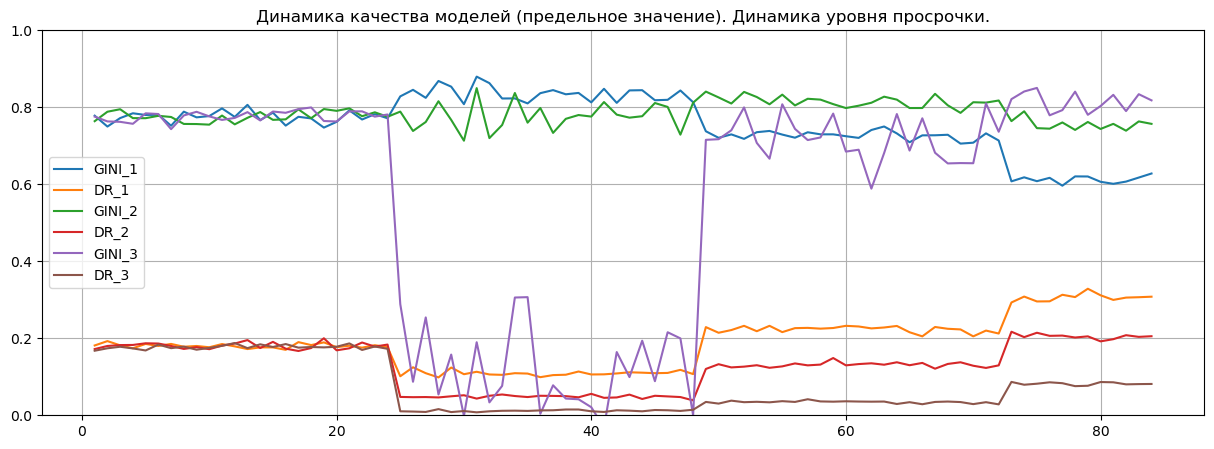

In [275]:
plt.figure(figsize=[15,5])
plt.ylim([0,None])
leg = []
for p in portfolio_list:
    plt.plot(D_fate[p])
    leg = leg + list(D_fate[p].columns)
plt.legend(leg)
plt.title('Динамика качества моделей (предельное значение). Динамика уровня просрочки.')
plt.grid()
plt.show()